In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [3]:
project = 'fvcom'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 50

In [5]:
grid_x = np.load(f'{project_root}/data/{project}/grid_x.npy')
grid_y = np.load(f'{project_root}/data/{project}/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

u1 = np.load(f'{project_root}/data/{project}/u_interp.npy') 
u2 = np.load(f'{project_root}/data/{project}/v_interp.npy')
nt, n1, n2 = u1.shape
mask = ~np.isnan(u1[0,:,:])

X, scaler = transform_data_for_AE(u1,u2)
data = transform_data_for_AE_inverse(X, scaler)

In [6]:
# === Consistent train/val/test split ===
n_train = int(0.3 * nt)
n_val = int(0.2 * nt)
n_test = nt - n_train - n_val

train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + n_val)
test_idx = np.arange(n_train + n_val, nt)

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (4642, 2, 64, 64), Val shape: (3095, 2, 64, 64), Test shape: (7738, 2, 64, 64)


In [7]:
MLP_input_dim = X[:, :, mask].reshape(X.shape[0], -1).shape[1]

In [8]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl')
mlp = MLP_AE(input_dim=MLP_input_dim, latent_dim=latent_dim, mask=mask)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'))
cnn.to(device);

In [9]:
# Compute test error for each model
mask_broadcast = mask[None, :, :]  # shape (1, n1, n2)

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)
pca_test_mse = np.mean((data[test_idx][:, :, mask] - X_pca_recon[test_idx][:, :, mask]) ** 2)
print(f"PCA test RMSE: {np.sqrt(pca_test_mse):.6f}")

# 2. PCA + MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

    mlp_test_mse = np.mean((data[test_idx][:, :, mask] - X_mlp_recon[test_idx][:, :, mask]) ** 2)
print(f"MLP AE test RMSE: {np.sqrt(mlp_test_mse):.6f}")

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
cnn_test_mse = np.mean((data[test_idx][:, :, mask] - X_cnn_recon[test_idx][:, :, mask]) ** 2)
print(f"CNN AE test RMSE: {np.sqrt(cnn_test_mse):.6f}")

PCA test RMSE: 0.050850
MLP AE test RMSE: 0.054133


/home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


CNN AE test RMSE: 0.055151


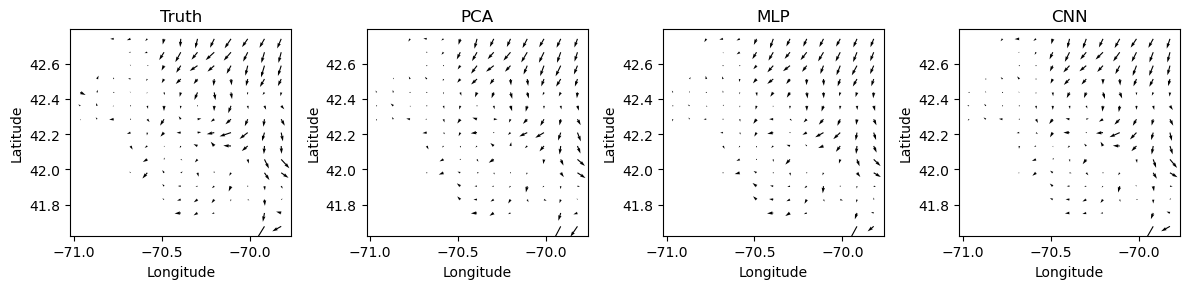

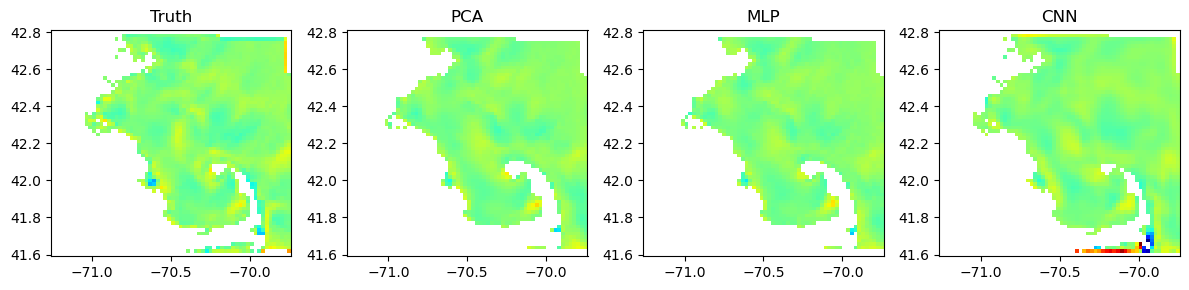

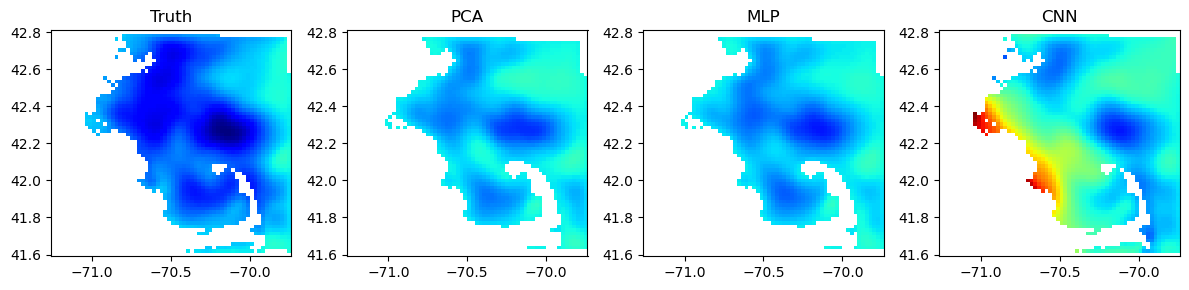

In [ ]:
# Choose a timestep to visualize
timestep = 1000

# Compute vorticity and streamfunction for each method
fields = {
    'Truth': (data[timestep, 0], data[timestep, 1]),
    'PCA': (X_pca_recon[timestep, 0], X_pca_recon[timestep, 1]),
    'MLP': (X_mlp_recon[timestep, 0], X_mlp_recon[timestep, 1]),
    'CNN': (X_cnn_recon[timestep, 0], X_cnn_recon[timestep, 1]),
}

omega = {}
psi = {}
for key, (u, v) in fields.items():
    o = vort_FVCOM(u, v, grid_x_m, grid_y_m)
    p = streamfunction_FVCOM(o, grid_x_m, grid_y_m)
    o[~mask], p[~mask] = np.nan, np.nan
    omega[key] = o
    psi[key] = p

# Plot velocity fields (quiver)
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
step = 4
xq, yq, mask_q = grid_x[::step, ::step], grid_y[::step, ::step], mask[::step, ::step]
for i, (key, (u, v)) in enumerate(fields.items()):
    axs[i].quiver(xq[mask_q], yq[mask_q], u[::step, ::step][mask_q], v[::step, ::step][mask_q], scale=7, scale_units='xy')
    axs[i].set_title(key)
    axs[i].set_aspect('equal')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
plt.tight_layout()
plt.show()

# Helper for contour plots
def plot_contours(data_dict, title, grid_x, grid_y):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    vmin = min(np.nanmin(arr) for arr in data_dict.values())
    vmax = max(np.nanmax(arr) for arr in data_dict.values())
    for i, (key, arr) in enumerate(data_dict.items()):
        axs[i].contourf(grid_x, grid_y, arr, levels=20, vmin=vmin, vmax=vmax, cmap='jet')
        axs[i].set_title(key)
    plt.tight_layout()
    plt.show()

plot_contours(omega, 'Vorticity', grid_x, grid_y)
plot_contours(psi, 'Streamfunction', grid_x, grid_y)
